# Reuters Story Categorization

## Step 1: Define the Problem & Collect Data

**Q**: What are you trying to predict?<br/>
**A**: Classifying newswires into categories.


**Q**: What will your input data be?<br/>
**A**: Newswires text.


**Q**: What type of problem are you facing?<br/>
**A**: Multi-label multi-class classification


**Q**: What is the size of your dataset?<br/>
**A**: 8982 training examples, 2246 test examples

In [1]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Step 2: Pick Success Metrics

**Q**: What is your metric for success?<br/>
**A**: Accuracy

**Q**: What value of your success metric are you aiming for?<br/>
**A**: 90%

## Step 3: Pick an Evaluation Protocol and Prepare Your Data

**Q**: What approach are going to follow for validation?<br/>
**A**: Hold out validation

**Q**: Does your data require reformatting (into tensors), normalization or scaling?<br/>
**A**: Yes, Training samples are arrays of arbitrary length. We will convert them into one-hot vectors. The labels are 0 or 1, so we just need to convert them to floating point numbers.

**Q**: What is the training/validation/test split?
**A**: We will set apart 1000 samples from the training set for validation.

**Q**: Can/should the data be randomized before splitting?<br/>
**A**: Not required. The reviews are already in random order

**Q**: Can you come up with new features using existing ones to make the problem easier?<br/>
**A**: Not required.

In [2]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Reformat the training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [3]:
from keras.utils import to_categorical

# Reformat the training and test labels
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [4]:
partial_x_train = x_train[1000:]
partial_y_train = y_train[1000:]

x_validation = x_train[:1000]
y_validation = y_train[:1000]

## Step 4: Develop the First Model

In [33]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_37 (Dense)             (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(
    partial_x_train, 
    partial_y_train, 
    epochs=20, 
    batch_size=512, 
    validation_data=(x_validation, y_validation))

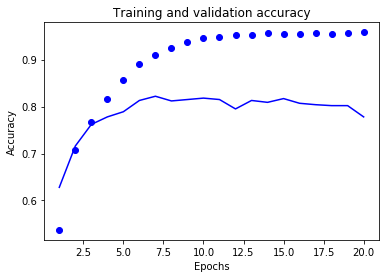

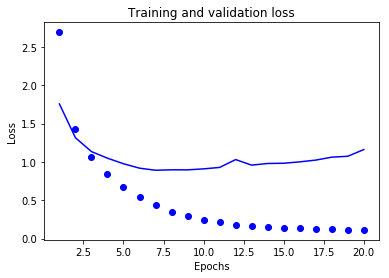

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs[0:], acc[0:], 'bo', label='Training acc')
plt.plot(epochs[0:], val_acc[0:], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.margins(0.05)

plt.figure()

plt.plot(epochs[0:], loss[0:], 'bo', label='Training loss')
plt.plot(epochs[0:], val_loss[0:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.margins(0.05)

plt.show()

## Step 5: Develop a Model That Overfits

The final objective is to find the balance between:
* Optimization and generalization
* Under-fitting and over-fitting
* Under-capacity and over-capacity

To figure out how big a model is required, you must develop a model that overfits, using one or more of the following approaches:
* Add layers
* Makes layers bigger
* Train for more epochs

Plot the values of the loss function and the success metrics on the training and validation datasets to identify where the model starts over-fitting.

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=9, 
    batch_size=512)

## Step 6: Regularize the Model and Tune the Hyperparameters

This part will take the most time. You will repeatedly modify your model, train it, evaluate on your validation data, modify it again... until your model is as good as it can get.

Following are some approaches for improving the model:
* Add dropout
* Try different architectures, add or remove layers
* Add L1 / L2 regularization
* Try different hyperparameters to find the optimal cofiguration, e.g.:
    * No. of units per layer
    * Learning rate of the optimizer
* Iterate on feature engineering: add new features, remove features that do not seem informative

Be mindful of the following: every time you are using feedback from your validation process in order to tune your model, you are leaking information about your validation process into your model. This can cause overfitting on the validation data.

Once you have developed a seemingly good enough model configuration, you can train your final production model on all data available (training and validation) and evaluate it one last time on the test set. Finally, you can save your model to disk, so that it can be reused later.

In [24]:
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    partial_x_train, 
    partial_y_train, 
    epochs=13, 
    batch_size=512, 
    validation_data=(x_validation, y_validation), )

Train on 7982 samples, validate on 1000 samples
Epoch 1/13
7982/7982 [==============================] - 1s 115us/step - loss: 2.8498 - acc: 0.4835 - val_loss: 1.8876 - val_acc: 0.6390
Epoch 2/13
7982/7982 [==============================] - 1s 68us/step - loss: 1.7224 - acc: 0.6606 - val_loss: 1.5124 - val_acc: 0.7020
Epoch 3/13
7982/7982 [==============================] - 1s 68us/step - loss: 1.3932 - acc: 0.7259 - val_loss: 1.3589 - val_acc: 0.7230
Epoch 4/13
7982/7982 [==============================] - 1s 68us/step - loss: 1.2123 - acc: 0.7665 - val_loss: 1.2683 - val_acc: 0.7460
Epoch 5/13
7982/7982 [==============================] - 1s 69us/step - loss: 1.0732 - acc: 0.8016 - val_loss: 1.2252 - val_acc: 0.7610
Epoch 6/13
7982/7982 [==============================] - 1s 69us/step - loss: 0.9767 - acc: 0.8221 - val_loss: 1.1728 - val_acc: 0.7950
Epoch 7/13
7982/7982 [==============================] - 1s 69us/step - loss: 0.8992 - acc: 0.8485 - val_loss: 1.1538 - val_acc: 0.7980
Epoch 

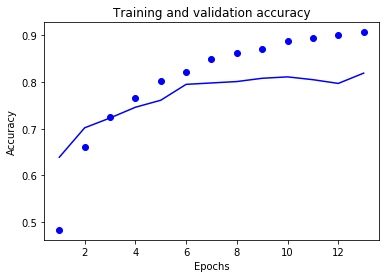

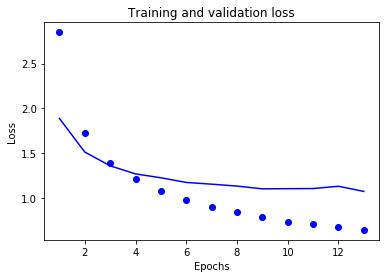

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs[0:], acc[0:], 'bo', label='Training acc')
plt.plot(epochs[0:], val_acc[0:], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.margins(0.05)

plt.figure()

plt.plot(epochs[0:], loss[0:], 'bo', label='Training loss')
plt.plot(epochs[0:], val_loss[0:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.margins(0.05)

plt.show()

In [32]:
result = model.evaluate(x_test, y_test)
print(result)

2246/2246 [==============================] - 0s 107us/step
[1.3068040470299929, 0.77649154056954994]


In [35]:
model.save('../models/02_retuers.h5')